# Approach 1: LeNet 
![LeNet Architecture](./lenet.png)
Source: Yan LeCun

### Load Data

Load the MNIST data, which comes pre-loaded with TensorFlow.

In [1]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.

Image Shape: (28, 28, 1)

Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples


The MNIST data that TensorFlow pre-loads comes as 28x28x1 images.

However, the LeNet architecture only accepts 32x32xC images, where C is the number of color channels.

In order to reformat the MNIST data into a shape that LeNet will accept, the data is padded with two rows of zeros on the top and bottom, and two columns of zeros on the left and right (28+2+2 = 32).

In [2]:
import numpy as np

# Pad images with 0s
X_train      = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 1)


### Visualize Data

View a sample from the dataset.

2


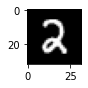

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

### Preprocess Data

Shuffle the training data.

In [4]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

### Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` and `learning rate` values affect the training speed, model accuracy and rate of learning.

In [5]:
import tensorflow as tf

EPOCHS = 50
BATCH_SIZE = 100
rate = 0.001

### LENET-5 architecture

In [6]:
import tensorflow as tf
lenet_5_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='tanh', input_shape = X_train[0].shape, padding='same'), # Conv2D layer 1
    tf.keras.layers.AveragePooling2D(), # Sub sampling layer 1
    tf.keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid'), # Conv2D layer 2
    tf.keras.layers.AveragePooling2D(), # Sub sampling layer 2
    tf.keras.layers.Flatten(), # Flatten
    tf.keras.layers.Dense(120, activation='tanh'), # Fully connected layer
    tf.keras.layers.Dense(84, activation='tanh'), # Fully connected layer
    tf.keras.layers.Dense(10, activation='softmax') # Output layer
])

optimizer = tf.train.AdamOptimizer(learning_rate = rate)

lenet_5_model.compile(optimizer, loss = tf.keras.losses.sparse_categorical_crossentropy, metrics = ["acc"])

history = lenet_5_model.fit(X_train, y_train, epochs=EPOCHS, batch_size = BATCH_SIZE, validation_data=(X_validation, y_validation))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 18s 321us/sample - loss: 0.3158 - acc: 0.9064 - val_loss: 0.1413 - val_acc: 0.9606
Epoch 2/50
55000/55000 [==============================] - 18s 328us/sample - loss: 0.1187 - acc: 0.9643 - val_loss: 0.0912 - val_acc: 0.9730
Epoch 3/50
55000/55000 [==============================] - 18s 336us/sample - loss: 0.0790 - acc: 0.9756 - val_loss: 0.0748 - val_acc: 0.9786
Epoch 4/50
55000/55000 [==============================] - 19s 341us/sample - loss: 0.0576 - acc: 0.9827 - val_loss: 0.0638 - val_acc: 0.9816
Epoch 5/50
55000/55000 [==============================] - 17s 302us/sample - loss: 0.0454 - acc: 0.9866 - val_loss: 0.0532 - val_acc: 0.9858
Epoch 6/50
55000/55000 [==============================] - 18s 329us/sample - loss: 0.0364 - acc: 0.9888 - val_loss: 0.0445 - val

### Testing the model

In [7]:
lenet_5_model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 141us/sample - loss: 0.0572 - acc: 0.9875


[0.0571769010866971, 0.9875]

### Plot the graphs

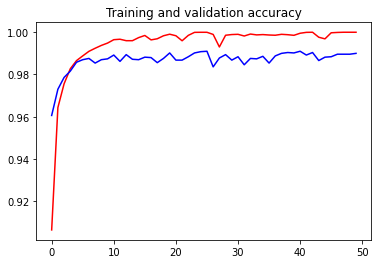

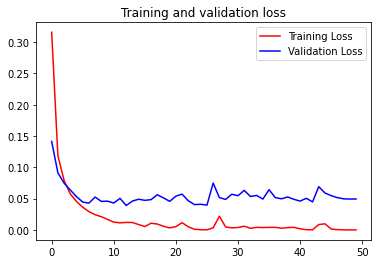

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

# Approach 2: Traditional neural network

![Neural Network Architecture](./ANN.png)

### Load data

Load the MNIST data, which comes pre-loaded with TensorFlow.

In [9]:
mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Image Shape: (28, 28, 1)

Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples


### Traditional Neural Network Architecture

In [10]:
ANN_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='tanh'), # Fully connected layer,
    tf.keras.layers.Dense(10, activation='softmax', input_shape = X_train[0].shape) # Output layer
])

optimizer = tf.train.AdamOptimizer(learning_rate = rate)

ANN_model.compile(optimizer, loss = tf.keras.losses.sparse_categorical_crossentropy, metrics = ["acc"])

history = ANN_model.fit(X_train, y_train, epochs=EPOCHS, batch_size = BATCH_SIZE, validation_data=(X_validation, y_validation))

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 1s 18us/sample - loss: 0.5143 - acc: 0.8647 - val_loss: 0.2776 - val_acc: 0.9246
Epoch 2/50
55000/55000 [==============================] - 1s 15us/sample - loss: 0.2614 - acc: 0.9250 - val_loss: 0.2263 - val_acc: 0.9334
Epoch 3/50
55000/55000 [==============================] - 1s 15us/sample - loss: 0.2147 - acc: 0.9385 - val_loss: 0.1939 - val_acc: 0.9444
Epoch 4/50
55000/55000 [==============================] - 1s 20us/sample - loss: 0.1846 - acc: 0.9475 - val_loss: 0.1759 - val_acc: 0.9516
Epoch 5/50
55000/55000 [==============================] - 1s 16us/sample - loss: 0.1641 - acc: 0.9532 - val_loss: 0.1687 - val_acc: 0.9546
Epoch 6/50
55000/55000 [==============================] - 1s 20us/sample - loss: 0.1483 - acc: 0.9580 - val_loss: 0.1561 - val_acc: 0.9552
Epoch 7/50
55000/55000 [==============================] - 1s 18us/sample - loss: 0.1356 - acc: 0.9605 - val_loss: 0.1

### Testing the model

In [11]:
ANN_model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 21us/sample - loss: 0.1796 - acc: 0.9579


[0.17963510226608487, 0.9579]

### Plot the graphs

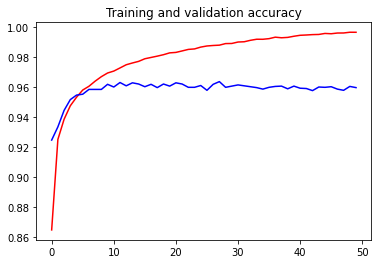

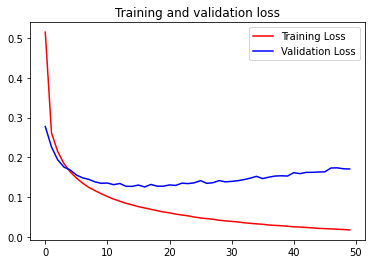

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()